In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evaluate
import random

In [2]:
bleu_metric = evaluate.load("bleu")

In [3]:
result_dir = "../model_outputs"
result_files = [os.path.join(result_dir, file) for file in os.listdir(result_dir) if ".json" in file]
len(result_files)

45

In [4]:
def get_df(result_file):
    with open(result_file, 'r') as f:
        data = json.load(f)
    f.close()
    df = pd.DataFrame(zip(data['preds'], data['references']), columns=['preds', 'gold'])
    return df

In [5]:
def get_bleu(preds, golds):
    bleu_scores = []
    for pred, gold in zip(preds, golds):
        bleu_score = bleu_metric.compute(predictions=[pred], references=[gold])
        bleu_scores.append(round(bleu_score['bleu']*100, 4))
    return bleu_scores

In [6]:
def get_token_length(examples):
    model_inputs = tokenizer(examples)
    return len(model_inputs['input_ids'])

In [7]:
from transformers import AutoTokenizer

In [8]:
tokenizer = AutoTokenizer.from_pretrained('Salesforce/codet5p-770m')

# CodexGLEU Code Trans

In [9]:
code_tans_files = [file for file in result_files if "codexglue_c2c_code_trans" in file and "test_outputs" in file]
len(code_tans_files), code_tans_files

(2,
 ['../model_outputs/hf_out-codet5-codet5p_770m-codexglue_c2c_code_trans-cs2java-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-codexglue_c2c_code_trans-java2cs-test_outputs.json'])

In [10]:
df_dict = {code_tans_file.split('codexglue_c2c_code_trans-')[-1].split('-test_outputs.json')[0]: get_df(code_tans_file) for code_tans_file in code_tans_files}
for key, val in df_dict.items():
    df = df_dict[key]
    df['bleu'] = get_bleu(df['preds'].tolist(), df['gold'].tolist())
    df['length'] = df['gold'].apply(lambda x: get_token_length(x[0]))
    df_dict[key] = df
    print(key, val.shape)

cs2java (1000, 4)
java2cs (1000, 4)


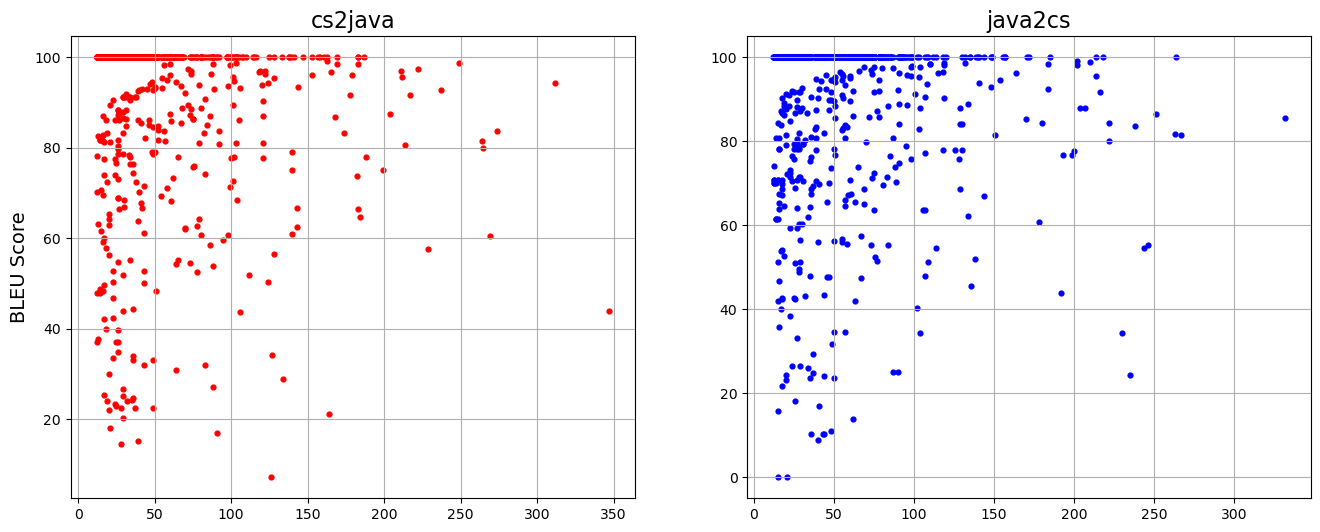

In [11]:
fig, s1 = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax1, ax2 = s1
axes = [ax1, ax2]

cnt = 0
color = ['red', 'blue']
for axis, (lang, df) in zip(axes, df_dict.items()):
    axis.scatter(df['length'], df['bleu'], marker='o', color=color[cnt], s=12)
    if cnt >= 4:
        axis.set_xlabel('Num tokens', fontsize=14)
    if cnt in [0, 4]:
        axis.set_ylabel(f'BLEU Score', fontsize=14)
    # axis.legend(loc='lower right', fontsize=18)
    axis.set_title(lang, fontsize=16)
    axis.grid(True)
    cnt += 1

plt.savefig("plots/codegluex_code_trans_token_bleu_pareto.pdf", dpi=600)

plt.show()

# # CodexGLEU Doc Trans

In [12]:
doc_tans_files = [file for file in result_files if "code_x_glue_tt_text" in file and "test_outputs" in file]
len(doc_tans_files), doc_tans_files

(8,
 ['../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_tt_text_to_text-zh2en-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_tt_text_to_text-en2da-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_tt_text_to_text-en2no-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_tt_text_to_text-no2en-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_tt_text_to_text-lv2en-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_tt_text_to_text-en2zh-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_tt_text_to_text-da2en-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_tt_text_to_text-en2lv-test_outputs.json'])

In [13]:
df_dict = {doc_tans_file.split('code_x_glue_tt_text_to_text-')[-1].split('-test_outputs.json')[0]: get_df(doc_tans_file) for doc_tans_file in doc_tans_files}
for key, val in df_dict.items():
    df = df_dict[key]
    df['bleu'] = get_bleu(df['preds'].tolist(), df['gold'].tolist())
    df['length'] = df['gold'].apply(lambda x: get_token_length(x[0]))
    df_dict[key] = df
    print(key, val.shape)

zh2en (1000, 4)
en2da (1000, 4)
en2no (1000, 4)
no2en (1000, 4)
lv2en (1000, 4)


Token indices sequence length is longer than the specified maximum sequence length for this model (656 > 512). Running this sequence through the model will result in indexing errors


en2zh (1000, 4)
da2en (1000, 4)
en2lv (1000, 4)


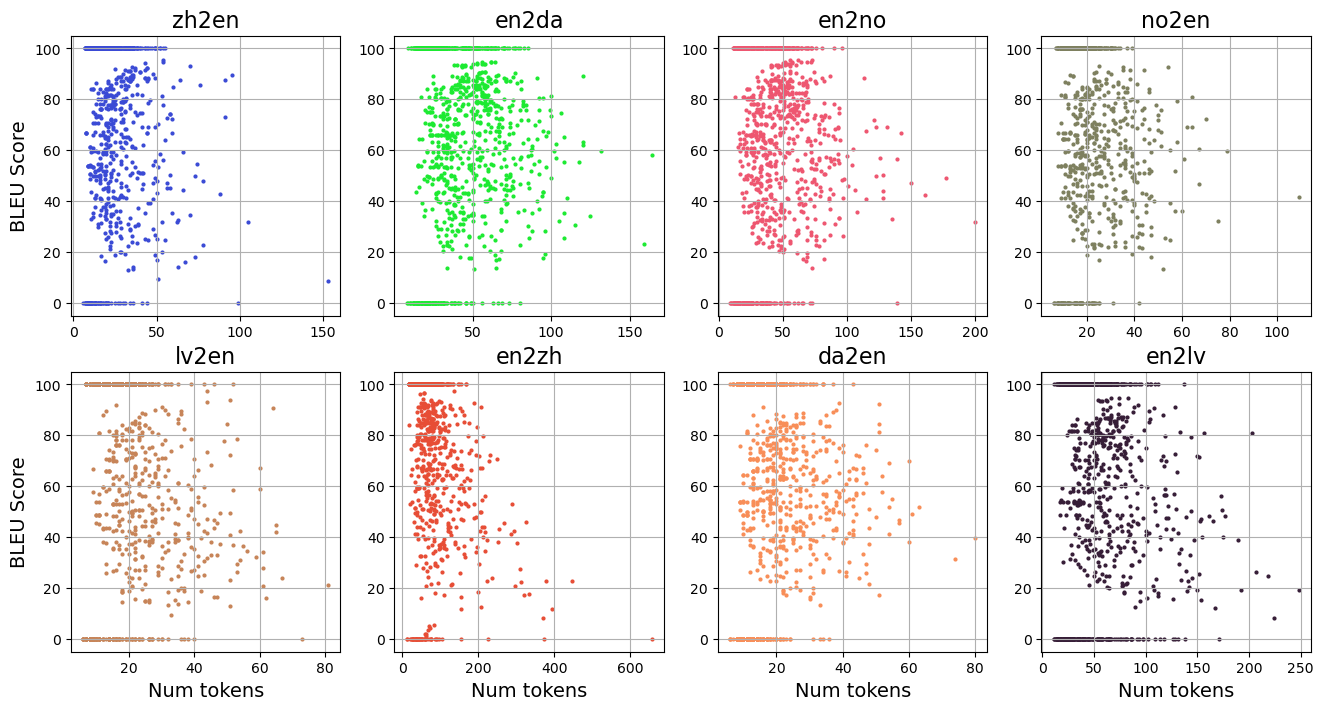

In [15]:
fig, (s1, s2) = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

ax1, ax2, ax3, ax4 = s1
ax5, ax6, ax7, ax8 = s2

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

hexadecimal_alphabets = '0123456789ABCDEF'
number_of_colors = len(df_dict)
color = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in
range(6)]) for i in range(number_of_colors)]

cnt = 0
for axis, (lang, df) in zip(axes, df_dict.items()):
    axis.scatter(df['length'], df['bleu'], marker='o', color=color[cnt], s=4)
    if cnt >= 4:
        axis.set_xlabel('Num tokens', fontsize=14)
    if cnt in [0, 4]:
        axis.set_ylabel(f'BLEU Score', fontsize=14)
    # axis.legend(loc='lower right', fontsize=18)
    axis.set_title(lang, fontsize=16)
    axis.grid(True)
    cnt += 1

plt.savefig("plots/codegluex_doc_trans_token_bleu_pareto.pdf", dpi=600)

plt.show()

# NL to PL and PL to NL

In [16]:
trans_files = [file for file in result_files if "test_outputs" in file and "code_x_glue_ct_code_to_text" in file and "en2" not in file]
len(trans_files), trans_files

(6,
 ['../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_ct_code_to_text-javascript2en-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_ct_code_to_text-go2en-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_ct_code_to_text-ruby2en-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_ct_code_to_text-php2en-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_ct_code_to_text-java2en-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_ct_code_to_text-python2en-test_outputs.json'])

In [17]:
df_dict = {trans_file.split('code_x_glue_ct_code_to_text-')[-1].split('-test_outputs.json')[0]: get_df(trans_file) for trans_file in trans_files}
for key, val in df_dict.items():
    df = df_dict[key]
    df['bleu'] = get_bleu(df['preds'].tolist(), df['gold'].tolist())
    df['length'] = df['gold'].apply(lambda x: get_token_length(x[0]))
    df_dict[key] = df
    print(key, val.shape)

javascript2en (777, 4)
go2en (1465, 4)
ruby2en (280, 4)
php2en (2596, 4)
java2en (1037, 4)
python2en (2783, 4)


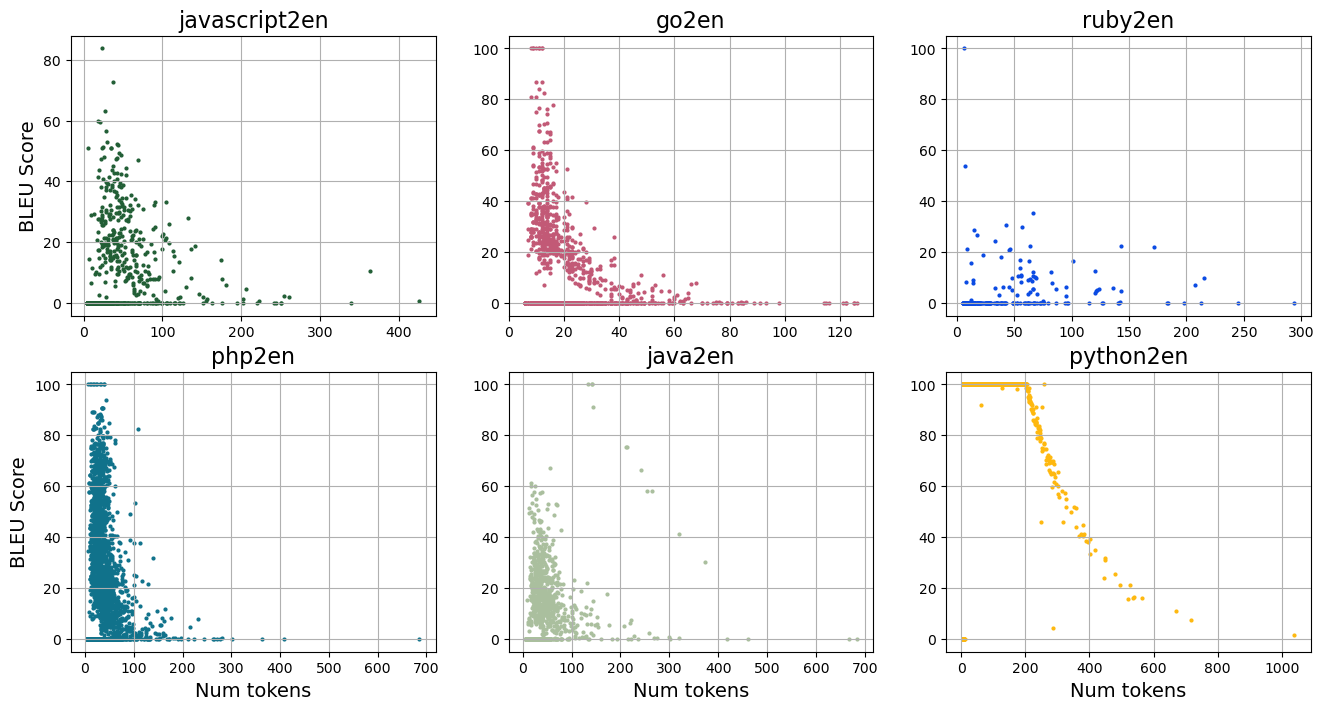

In [28]:
fig, (s1, s2) = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

ax1, ax2, ax3  = s1
ax4, ax5, ax6 = s2

axes = [ax1, ax2, ax3, ax4, ax5, ax6]

hexadecimal_alphabets = '0123456789ABCDEF'
number_of_colors = len(df_dict)
color = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in
range(6)]) for i in range(number_of_colors)]

cnt = 0
for axis, (lang, df) in zip(axes, df_dict.items()):
    axis.scatter(df['length'], df['bleu'], marker='o', color=color[cnt], s=4)
    if cnt >= 3:
        axis.set_xlabel('Num tokens', fontsize=14)
    if cnt in [0, 3]:
        axis.set_ylabel(f'BLEU Score', fontsize=14)
    # axis.legend(loc='lower right', fontsize=18)
    axis.set_title(lang, fontsize=16)
    axis.grid(True)
    cnt += 1

plt.savefig("plots/codegluex_pl_nl_token_bleu_pareto.pdf", dpi=600)

plt.show()